In [1]:
import numpy as np 
import statsmodels.api as sm
import pandas as pd 
import matplotlib.pyplot as plt



In [4]:
fed_interest = pd.read_csv('FEDFUNDS.csv', index_col= 0)
euro_interst = pd.read_csv('INTDSREZM193N.csv', index_col = 0)


fed_interest.index = pd.to_datetime(fed_interest.index, format = "%Y-%m-%d")

fed_interest['FED FUNDS PCT CHANGE'] = fed_interest['FEDFUNDS'].diff()
fed_interest['Intercept'] = 1 

euro_interst['EURO PCT CHANGE'] = euro_interst['INTDSREZM193N'].pct_change()
euro_interst['Intercept'] = 1 

fed_interest

,FEDFUNDS,FED FUNDS PCT CHANGE,Intercept
DATE,,,
1999-01-01,4.63,NaN,1
1999-02-01,4.76,0.13,1
1999-03-01,4.81,0.05,1
1999-04-01,4.74,-0.07,1
1999-05-01,4.74,0.00,1
...,...,...,...
2017-01-01,0.65,0.11,1
2017-02-01,0.66,0.01,1
2017-03-01,0.79,0.13,1


In [7]:
dependent = fed_interest.loc["1999-02-01": , ['FED FUNDS PCT CHANGE']].reset_index()
independent = fed_interest.loc["1999-01-01" : "2017-04-01", ['FEDFUNDS', 'Intercept']].reset_index()

dependent = dependent[['FED FUNDS PCT CHANGE']]
independent = independent[['FEDFUNDS', 'Intercept']]

In [8]:
results = sm.regression.linear_model.OLS(dependent, independent)
results = results.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     FED FUNDS PCT CHANGE   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     1.356
Date:                  Wed, 16 Oct 2024   Prob (F-statistic):              0.246
Time:                          15:39:11   Log-Likelihood:                 79.063
No. Observations:                   220   AIC:                            -154.1
Df Residuals:                       218   BIC:                            -147.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEDFUNDS      -0.0063      0.005     -1.164      0.246      -0.017       0.004
Intercept     -0.0046      0.016     -0.294      0.769      -0.035       0.026
==============================================================================
Omnibus:                      119.929   Durbin-Watson:                   0.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.525
Skew:                          -2.117   Prob(JB):                    5.64e-152
Kurtosis:                      10.619   Cond. No.                         4.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

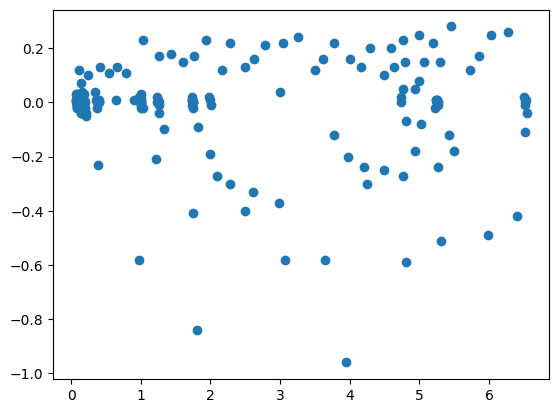

In [10]:
plt.scatter(independent['FEDFUNDS'], dependent)
plt.show()

In [11]:
residuals = results.resid
sigma = np.var(residuals,ddof=218)

In [12]:
steps_per_year=12
n_years = 5
dt = 1/steps_per_year
n_scenarios=100
n_steps = int(n_years*steps_per_year) + 1
xi = np.random.normal(loc = 0, scale = 1, size=(n_steps, n_scenarios))
xi

array([[ 1.14204495,  0.94492705, -1.43754436, ..., -1.63065456,
         1.2288792 ,  0.4679401 ],
       [ 0.51254876,  0.22680356,  1.3380833 , ...,  1.95678665,
         0.26227199, -0.64686081],
       [-0.25675053, -0.10560444, -0.22708385, ...,  1.80830703,
        -0.5151797 ,  0.62409685],
       ...,
       [-0.76878409,  0.19380604, -0.63354175, ...,  2.00171831,
         0.12575454, -0.66899596],
       [ 0.40305599, -0.2086579 , -0.36975363, ...,  0.21257714,
         1.51182738,  0.82065706],
       [-0.05656313, -0.20318715, -1.93912446, ..., -1.2427063 ,
         1.78760668,  1.39907986]])

<Axes: >

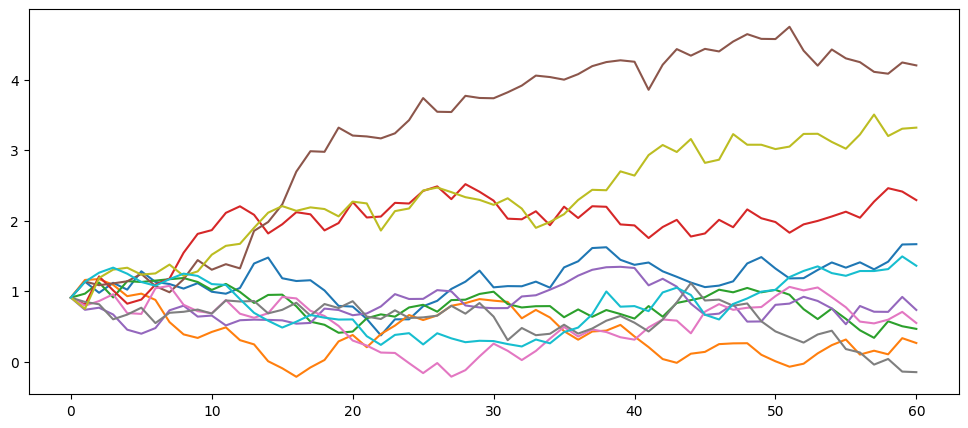

In [13]:


def Vasicek(n_years=5, n_scenarios=100, sigma=sigma, steps_per_year=12, s_0=0.91, prices=True):
    """
    Evolution of Vasicek trajectories, such as for interest rate through OLS Regression
    :param n_years:  The number of years to generate data for
    :param n_scenarios: The number of scenarios/trajectories
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_scenarios columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year) + 1
    xi = np.random.normal(loc=0, scale=1, size=(n_steps, n_scenarios))
    
    # Initialize the interest rate array
    rt = np.zeros((n_steps, n_scenarios))
    rt[0] = s_0
    
    # Generate the interest rate path
    for t in range(1, n_steps):
        rt_t_minus_1 = rt[t-1]
        mu = -0.0046 - (-0.0063* rt_t_minus_1)
        change = mu * dt + sigma  * xi[t]
        rt[t] = rt_t_minus_1 + change
    
    # Convert to DataFrame if needed
    if prices:
        rt = pd.DataFrame(rt)
    
    return rt



Vasicek(n_years=5, n_scenarios=10, sigma = 0.15, s_0 = 0.91, prices=True).plot(figsize = (12,5), legend = False)


## CIR Model 
